In [13]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Importing Necessay Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# reading the data
data = pd.read_csv('Netflix-Subscriptions.csv')
print(data.head())

  Time Period  Subscribers
0  01/04/2013     34240000
1  01/07/2013     35640000
2  01/10/2013     38010000
3  01/01/2014     41430000
4  01/04/2014     46130000


In [15]:
data['Time Period'] = pd.to_datetime(data['Time Period'], format = '%d/%m/%Y')
print(data.head())
                                          

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


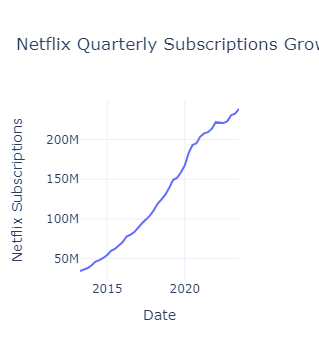

In [17]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Time Period'],
                         y=data['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions')
fig.show()


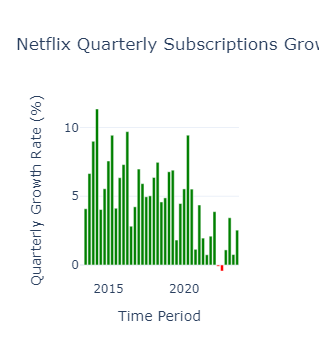

In [18]:
#Calculate the quarterly growth rate
data['Quarterly Growth Rate'] = data['Subscribers'].pct_change()*100

# Create a new column for bar color (green for positive growth,red for negative growth)
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Time Period'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

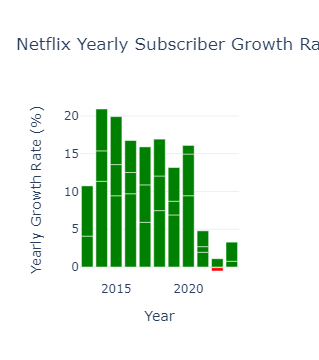

In [19]:
# Calculate the yearly growth rate
data['Year'] = data['Time Period'].dt.year
yearly_growth = data.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')
fig.show()

**Using ARIMA for Forecasting Netflix Quarterly Subscriptions**

In [24]:
time_series = data.set_index('Time Period')['Subscribers']

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



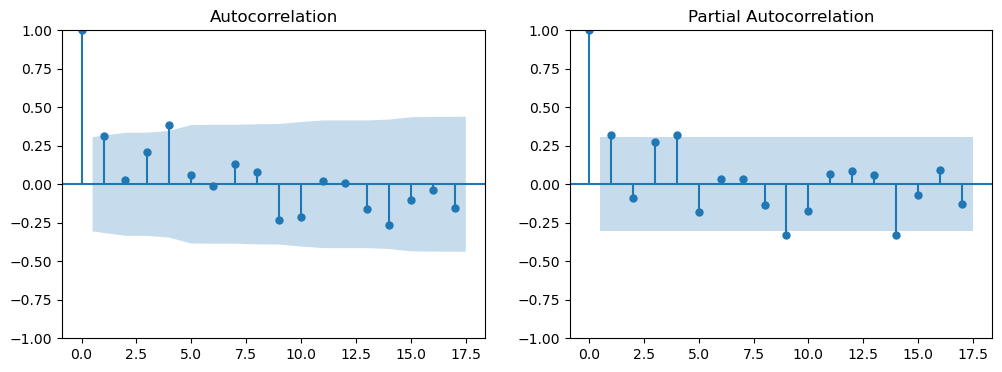

In [25]:
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [26]:
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Tue, 09 Jan 2024   AIC                           1351.986
Time:                        10:13:48   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.765      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



In [27]:
future_steps = 5
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)

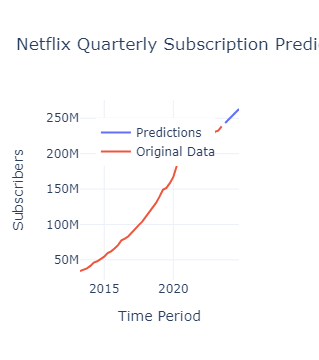

In [28]:
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()